# Classification binaire des photos

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz
import os
from tqdm.notebook import tqdm

In [ ]:
tf.debugging.set_log_device_placement(False)

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Chargement des données
D'abord, nous allons diviser nos données en 3 jeux de données différents.  
- 1 jeu pour entraîner le modèle
- 1 jeu pour valider la performance du modèle pendant l'entraînement
- 1 jeu pour tester la performance du modèle entraîné

In [ ]:
BATCH_SIZE = 128
IMG_SIZE = (150, 150)

# Ensemble d'entraînement (70% des données)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./processed_data/",
    validation_split=0.3,  # 30% pour la combinaison de validation + test
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_dataset = tf.keras.utils.image_dataset_from_directory(
    "./processed_data/",
    validation_split=0.3,  
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 61385 files belonging to 2 classes.
Using 42970 files for training.
Found 61385 files belonging to 2 classes.
Using 18415 files for validation.


## 2. Normalisation
Les pixels des images sont compris entre 0 et 255.   
Nous allons normaliser ces valeurs entre 0 et 1 car La normalisation des pixels des images rend l'entraînement du modèle plus rapide et plus stable, car elle assure que toutes les entrées ont des valeurs similaires.

In [ ]:
def plot_pixel_distribution(dataset, title="Pixel Distribution"):
    pixels = {}
    
    for images, _ in dataset:
        pixel_value, value_count = np.unique(images, return_counts=1)
        for i in range(len(pixel_value)):
            pixels[pixel_value[i]] = pixels.get(pixel_value[i], 0) + value_count[i]

    plt.figure(figsize=(10, 5))
    plt.hist(pixels.keys(), weights=pixels.values(), bins=256, alpha=0.5, density=True, histtype='bar', stacked=True)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

Voici la répartition des valeurs des pixels avant la normalisation.

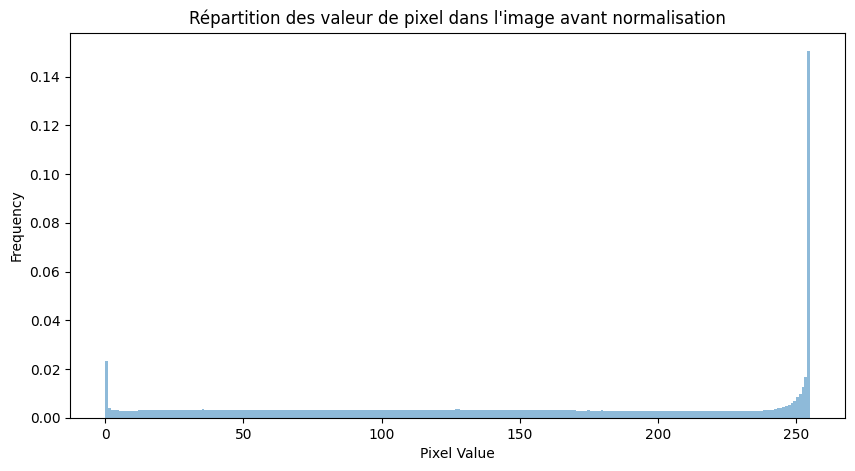

In [ ]:
plot_pixel_distribution(temp_dataset, 'Répartition des valeur de pixel dans l\'image avant normalisation')

In [ ]:
def normalize(image, label):
    return tf.multiply(image, 1./255), label

In [ ]:
train_dataset = train_dataset.map(normalize)

In [ ]:
temp_dataset = temp_dataset.map(normalize)

Voici la répartition des valeurs des pixels après la normalisation.

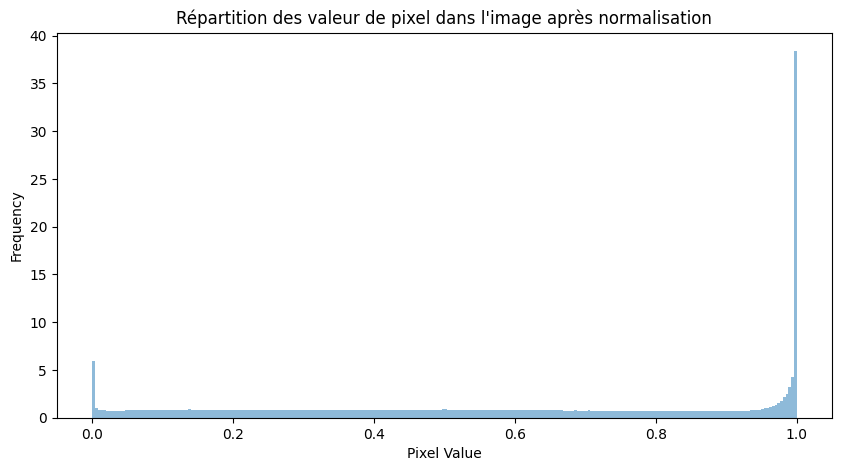

In [ ]:
plot_pixel_distribution(temp_dataset, 'Répartition des valeur de pixel dans l\'image après normalisation')

On peut voir ici que la répartition reste la même, alors que la plage des données est passée de 0-255 à 0-1. Cela permet de valider la réussite de la normalisation.

## 3. Tailles des jeux de données
Maintenant que nos données sont normalisées nous pouvons diviser notre jeu temporaire en 2 afin de créer les jeux de test et de validation.

In [ ]:
# Calculer le nombre total de lots dans temp_dataset
num_batches = len(temp_dataset)

# Diviser temp_dataset en deux
val_dataset = temp_dataset.take(num_batches // 2)
test_dataset = temp_dataset.skip(num_batches // 2)

In [ ]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += BATCH_SIZE
    return count

# Compter le nombre d'éléments dans chaque jeu de données
train_size = count_elements(train_dataset)
val_size = count_elements(val_dataset)
test_size = count_elements(test_dataset)

# Afficher la taille de chaque jeu de données
print(f"Taille du jeu d'entraînement: {train_size} images")
print(f"Taille du jeu de validation: {val_size} images")
print(f"Taille du jeu de test: {test_size} images")

Taille du jeu d'entraînement: 43008
Taille du jeu de validation: 9216
Taille du jeu de test: 9216


## 2. Construction du modèle

Le choix des couches de notre réseau de neuronnes est déterminant concernant sa précision.  
La tâche de classification binaire d'image nous a naturellement orienté sur les réseaux de neuronnes convolutifs.   
Après de nombreux essais sur les couches et les paramètres, voici une visualisation du modèle retenu :   
![image.png](./images/CNNCNN.png) 
   
Voici une description plus détaillée avec les couches de dropout qui évitent de concentrer les décisions sur seulement quelques neuronnes ainsi que la couche flatten qui permet d'applatir la donnée avant de la fournir au classifier.

In [ ]:
model = None
with tf.device('/GPU:0'):
    #Initialisation du modèle
    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Deuxième couche de convolution
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Troisième couche de convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 4eme couche de convolution
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplatir les résultats pour les connecter à une couche dense
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Couche de sortie
    model.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

## 3. Entraînement du modèle

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_directory = f"weights/checkpoint/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/15
336/336 [==============================] - 190s 555ms/step - loss: 0.4261 - accuracy: 0.7965 - val_loss: 0.3595 - val_accuracy: 0.8287
Epoch 2/15
336/336 [==============================] - 183s 544ms/step - loss: 0.3266 - accuracy: 0.8531 - val_loss: 0.2852 - val_accuracy: 0.8804
Epoch 3/15
336/336 [==============================] - 182s 541ms/step - loss: 0.2707 - accuracy: 0.8847 - val_loss: 0.2458 - val_accuracy: 0.8949
Epoch 4/15
336/336 [==============================] - 189s 562ms/step - loss: 0.2398 - accuracy: 0.8997 - val_loss: 0.2182 - val_accuracy: 0.9056
Epoch 5/15
336/336 [==============================] - 197s 584ms/step - loss: 0.2046 - accuracy: 0.9153 - val_loss: 0.2222 - val_accuracy: 0.9095
Epoch 6/15
336/336 [==============================] - 192s 569ms/step - loss: 0.1885 - accuracy: 0.9233 - val_loss: 0.2103 - val_accuracy: 0.9134
Epoch 7/15
336/336 [==============================] - 196s 583ms/step - loss: 0.1605 - accuracy: 0.9354 - val_loss: 0.2210 -

**Chargement des poids du modèle à la fin de la meilleure époque.**   
   
   
L'objectif est de charger les poids du modèle au moment de la meilleure époque, c'est à dire l'époque qui a la meilleure accuracy sur le jeu de validation mais qui n'est pas en sur-apprentissage (Avant que la perte du jeu de validation commence à augmenter et l'accuracy du jeu de validation reste à peu près stable. Dans ce cas, le modèle ne sera performant que sur les données d'entrainement et ne sera pas assez général).   
   
On charge donc les poids que le modèle avait à la fin de la meilleure époque.  
Voici un exemple d'entraînement de ce modèle :   
En vert, le jeu de validation et en rose le jeu d'entraînement.   
![image.png](./images/loss.png)
![image.png](./images/accuracy.png)   
   
Ici, nous allons charger les poids du modèle au moment de la 6ème époque.

In [ ]:
model.load_weights("./weights/checkpoint/20231004-113656/06-0.2103.h5")

## 4. Evaluation du modèle
Afin de valider le modèle, nous allons étudier sa performance sur le jeu de test, c'est à dire des images qu'il n'as jamais vu pendant l'entraînement.

### 4.1. Loss et Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

72/72 [==============================] - 14s 159ms/step - loss: 0.2217 - accuracy: 0.9126
Loss: 0.22173908352851868
Accuracy: 0.9125992059707642


On peut voir ici que le modèle effectue la bonne prédiction environ 9 fois sur 10.

### 4.2. Matrice de confusion

  0%|          | 0/72 [00:00<?, ?it/s]

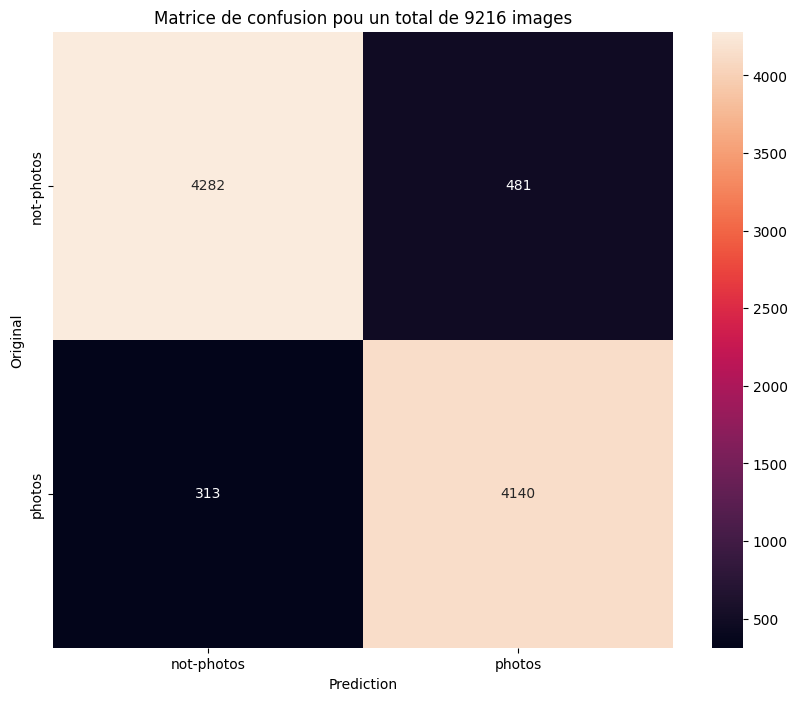

In [27]:
# Get the true labels and predictions
true_labels = []
predictions = []

for img, label in tqdm(val_dataset, leave=False):
    pred = model.predict(img, verbose=0)
    pred = tf.round(pred).numpy().flatten()  # Round the predictions to get binary output
    predictions.extend(pred)
    true_labels.extend(label.numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_labels, predictions)

# If you want to visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["not-photos", "photos"]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Original')
plt.title(f"Matrice de confusion pou un total de {true_labels.shape[0]} images")
plt.show()

Pour améliorer ce modèle, il faudrait réussir à limiter le nombre de faux positifs quitte à augmenter le nombre de faux négatifs. En effet, l'important ici est d'exclure les images qui ne sont pas des photos quitte à perdre quelques photos.

### 4.3. Visualisation des prédictions en erreur

288/288 [==============================] - 10s 35ms/step


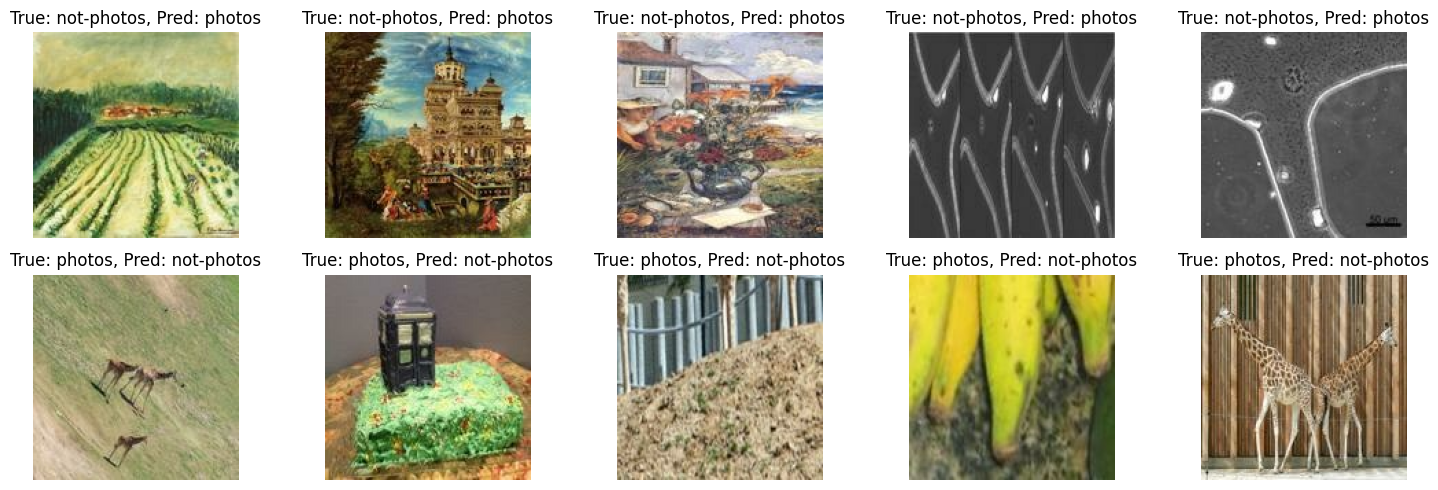

In [26]:
# Obtenez toutes les images et étiquettes du dataset pour éviter des appels répétés
all_images, all_labels = [], []
for img, label in val_dataset:
    all_images.extend(img.numpy())
    all_labels.extend(label.numpy())

# Convertissez les listes en numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Recalculez les prédictions pour toutes les images
all_predictions = model.predict(all_images)
all_predictions = tf.round(all_predictions).numpy().flatten()  # Arrondir les prédictions pour obtenir un résultat binaire

# Trouvez les indices des faux positifs et des faux négatifs
false_positive_indices = np.where((all_labels == 0) & (all_predictions == 1))[0]
false_negative_indices = np.where((all_labels == 1) & (all_predictions == 0))[0]

# Choisissez les 5 premiers faux positifs et faux négatifs
selected_fp_indices = false_positive_indices[:5]
selected_fn_indices = false_negative_indices[:5]

# Affichez les faux positifs
plt.figure(figsize=(15, 5))
for i, index in enumerate(selected_fp_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(all_images[index])
    plt.title(f"True: {class_names[int(all_labels[index])]}, Pred: {class_names[int(all_predictions[index])]}")
    plt.axis('off')

# Affichez les faux négatifs
for i, index in enumerate(selected_fn_indices, 1):
    plt.subplot(2, 5, i + 5)
    plt.imshow(all_images[index])
    plt.title(f"True: {class_names[int(all_labels[index])]}, Pred: {class_names[int(all_predictions[index])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Visualiser quelques erreurs de notre modèle permet de comprendre le genre d'images qui le met en difficulté.  
Généralement, les peintures et les photos en noir et blanc ont tendance à mettre le modèle en difficulté.  
Sentez-vous libre d'afficher plus de prédictions en erreur pour mieux comprendre les images difficiles.